# Table of Contents
 <p>

In [1]:
%load_ext autoreload
%matplotlib inline

In [83]:
%autoreload 2

import numpy as np
import dask.array as da
import matplotlib.pyplot as plt
import datetime as dt
import sys,os,glob
from mpl_toolkits.basemap import Basemap
from matplotlib.colors import LogNorm
from scipy.stats import gaussian_kde

## Add own library to path
workdir = os.getcwd()
moduledir = os.path.join(os.path.dirname(workdir),'functions')
sys.path.insert(0,moduledir)
print("Own modules available:", [os.path.splitext(os.path.basename(x))[0]
                                 for x in glob.glob(os.path.join(moduledir,'*.py'))])
## Load own libraries
from thermoConstants import *
from environmentAndDirectories import *
from importingData import *
from scalingApproximations import *
from slicingAndSubsetting import *

Own modules available: ['CAMsettings', 'daskOptions', 'environmentAndDirectories', 'importingData', 'physicalConstants', 'scalingApproximations', 'slicingAndSubsetting', 'statisticalDistributions', 'thermoConstants', 'thermoFunctions']


In [18]:
compset = 'FAMIPC5'
experiment = 'piControl'
subset = 'tropics'
time_stride = 'day'

historyFilesSettings = getCAMHistoryFilesSettings()

inputdir, inputdir_processed_day, inputdir_processed_1hr, inputdir_results, inputdir_fx = \
    getInputDirectories(compset,experiment)

daskarray = True
    
q_id = 'Q'
spechum = getValues(q_id,compset,subset,experiment,time_stride,daskarray=daskarray)
omega_id = 'OMEGA'
omega = getValues(omega_id,compset,subset,experiment,time_stride,daskarray=daskarray)
pr_id = 'PRECT'
pr = getValues(pr_id,compset,subset,experiment,time_stride,daskarray=daskarray)
ts_id = 'TS'
ts = getValues(ts_id,compset,subset,experiment,time_stride,daskarray=daskarray)
relhum_id = 'RELHUM'
relhum = getValues(relhum_id,compset,subset,experiment,time_stride,daskarray=daskarray)
ta_id = 'T'
ta = getValues(ta_id,compset,subset,experiment,time_stride,daskarray=daskarray)

Q found in history files
Importing Q from 25 files
  from
  /Users/bfildier/Data/simulations/bf_FAMIPC5_piControl/bf_FAMIPC5_piControl.cam.h0.1850-05-01-00000.nc
  to
  /Users/bfildier/Data/simulations/bf_FAMIPC5_piControl/bf_FAMIPC5_piControl.cam.h0.1850-05-02-00000.nc
OMEGA found in history files
Importing OMEGA from 25 files
  from
  /Users/bfildier/Data/simulations/bf_FAMIPC5_piControl/bf_FAMIPC5_piControl.cam.h0.1850-05-01-00000.nc
  to
  /Users/bfildier/Data/simulations/bf_FAMIPC5_piControl/bf_FAMIPC5_piControl.cam.h0.1850-05-02-00000.nc
PRECT found in history files
Importing PRECT from 25 files
  from
  /Users/bfildier/Data/simulations/bf_FAMIPC5_piControl/bf_FAMIPC5_piControl.cam.h0.1850-05-01-00000.nc
  to
  /Users/bfildier/Data/simulations/bf_FAMIPC5_piControl/bf_FAMIPC5_piControl.cam.h0.1850-05-02-00000.nc
TS found in history files
Importing TS from 25 files
  from
  /Users/bfildier/Data/simulations/bf_FAMIPC5_piControl/bf_FAMIPC5_piControl.cam.h0.1850-05-01-00000.nc
  to
  

In [4]:
## Get longitude, latitude and landmask

fh = Dataset(os.path.join(inputdir_fx,'landmask_fx_CESM111-SPCAM20_allExperiments_r0i0p0.nc'))
lon1D = fh.variables['lon'][:]
lat1D = fh.variables['lat'][:]
lon2D, lat2D = np.meshgrid(lon1D,lat1D)

print("Loading lontigude, latitude and landmask")

landmask = fh.variables['landmask']


Loading lontigude, latitude and landmask


In [5]:
input_lev_file = os.path.join(inputdir_fx,'lev_fx_CESM111-SPCAM20_allExperiments_r0i0p0.nc')
computeP = getPressureCoordinateFunction(input_lev_file)

In [11]:
ps_varid = 'PS'
ps = getValues(ps_varid,compset,subset,experiment,time_stride,daskarray=daskarray)
pres = computeP(ps)
cn = getArrayType(pres)

PS found in history files
Importing PS from 25 files
  from
  /Users/bfildier/Data/simulations/bf_FAMIPC5_piControl/bf_FAMIPC5_piControl.cam.h0.1850-05-01-00000.nc
  to
  /Users/bfildier/Data/simulations/bf_FAMIPC5_piControl/bf_FAMIPC5_piControl.cam.h0.1850-05-02-00000.nc


In [19]:
levdim = 1 
omega_pos = omega.copy()
omega_pos[omega > 0] = 0
qvstar = saturationSpecificHumidity(ta,pres)
dqvstar = cn.diff(qvstar,axis=levdim)
dq = cn.diff(spechum,axis=levdim)
dp = cn.diff(pres,axis=levdim) 
dq_dp = dq/dp
dqvstar_dp = dqvstar/dp

In [33]:
pr_est = -verticalPressureIntegral(pres,values=[omega],dvdp=dqvstar_dp,levdim=levdim)
pr_est_pos_omega = -verticalPressureIntegral(pres,values=[omega_pos],dvdp=dqvstar_dp,levdim=levdim)
detrained_est = verticalPressureIntegral(pres,values=[omega,1-relhum,qvstar],levdim=levdim)/gg
detrained_est_pos_omega = verticalPressureIntegral(pres,values=[omega_posdetrained_est = verticalPressureIntegral(pres,values=[omega,1-relhum,qvstar],levdim=levdim)/ggdetrained_est = verticalPressureIntegral(pres,values=[omega,1-relhum,qvstar],levdim=levdim)/gg,1-relhum,qvstar],levdim=levdim)/gg

In [14]:
pr_est.max().compute()
pr.max().compute()

7.953401e-07

In [82]:
print(np.isnan(pr).size,np.isnan(pr_est).size)

18432 18432


In [60]:
# Compute regression lines

x,y = pr_est.reshape(1,-1),pr.reshape(1,-1)

In [81]:
from scipy.stats import linregress

above = pr > 5e-8
# x,y = pr_est.reshape(1,-1),pr.reshape(1,-1)
x,y = pr_est[above],pr[above]
slope, intercept, r_value, p_value, std_err = linregress(x, y)
print(slope, intercept, r_value, p_value, std_err)

0.00185416334883 1.12303717493e-07 0.51016748263 1.03412344845e-283 4.7680233789e-05


ValueError: Invalid RGBA argument: 166378377119.41626

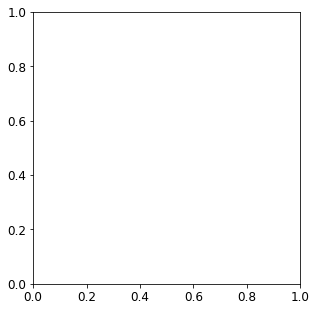

In [85]:
fig = plt.figure(figsize=(11,5))

ax = fig.add_subplot(121)

x_lims = (-1e-4,1e-4)
x_vals = np.linspace(x_lims[0],x_lims[1],100)

x,y = pr_est[above],pr[above]
xy = np.vstack([x,y])
z = gaussian_kde(xy)(xy)

plt.scatter(pr_est,pr,c=z,s=100,edgecolor='')
plt.plot(x_vals,(slope*x_vals+intercept))
plt.xlim((-1e-4,1e-4))
plt.ylim((-1e-7,1e-6))


ax = fig.add_subplot(122)

plt.scatter(pr_est_pos_omega,pr)
plt.ylim((-1e-7,1e-6))
plt.xlim((-1e-4,1e-4))

(-0.0002, 0.0002)

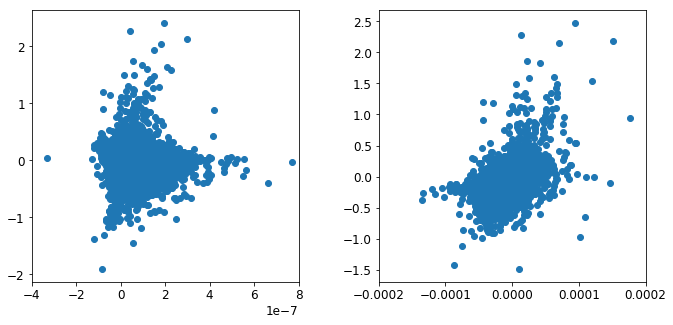

In [80]:
fig = plt.figure(figsize=(11,5))

ax = fig.add_subplot(121)

plt.scatter(pr-slope*pr_est,detrained_est)
plt.xlim((-4e-7,8e-7))
# plt.ylim((-1e-4,1e-4))

ax = fig.add_subplot(122)

plt.scatter(pr-pr_est_pos_omega,detrained_est_pos_omega)
plt.xlim((-2e-4,2e-4))
# plt.ylim((-1e-4,1e-4))